# Embedded ML - Lab 3: ML on Embedded GPUs

Tensor Flow Lite is not only a vehicle to export models to be used in Tensor Flow Lite Micro. It's also an interpreter to run inference on devices that have less resources than servers or standard computers, such as mobile phones, drones, network cameras, etc. In this lab we will use TF Lite to implement an ML application on an embedded platform that features a GPU.

### Learning outcomes


* Explain the differences between a TF Lite and a TF Lite environment
* Use the TF Lite API to implement an ML application on an embedded GPU
* Understand the performance differences between TF and TF Lite

### TensorFlow Lite workflow

We have already seen the TF Lite basic workflow in Lab 2.2. We will now use TF Lite on an embedded platform that includes a GPU device to understand its capabilities and limitations.

Run the following code on the **Jetson Nano board** and on a cloud or workstation GPU and compare their latencies. The code **trains** and exports a TF Lite model for classifying the Fashion MNIST dataset.

In [ ]:
!pip install pathlib
!pip install memory_profiler

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import time
import pathlib

# Load the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize the images to the range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Class names for the Fashion MNIST dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           	'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

model = models.Sequential([
	layers.Flatten(input_shape=(28, 28)),
	layers.Dense(128, activation='relu'),
	layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
          	loss='sparse_categorical_crossentropy',
          	metrics=['accuracy'])

start_time = time.time()
model.fit(train_images, train_labels, epochs=2)

print('\nFinished training and exporting model')
print("---Training time %s seconds ---" % (time.time() - start_time))


model_name = "fmnist"
tf.saved_model.save(model, model_name)

converter = tf.lite.TFLiteConverter.from_saved_model(model_name)
tflite_model = converter.convert()
tflite_model_file = pathlib.Path(model_name+".tflite")
tflite_model_file.write_bytes(tflite_model)

start_time = time.time()
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)
print("---Inference time %s seconds ---" % (time.time() - start_time))


4422102/4422102 [==============================] - 0s 0us/step
Epoch 1/2
1875/1875 [==============================] - 14s 5ms/step - loss: 0.4997 - accuracy: 0.8253
Epoch 2/2
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3734 - accuracy: 0.8654

Finished training and exporting model
---Training time 43.03936219215393 seconds ---
313/313 - 1s - loss: 0.3877 - accuracy: 0.8608 - 1s/epoch - 3ms/step

Test accuracy: 0.86080002784729
---Inference time 1.6523334980010986 seconds ---


|                    	| **Jetson** 	| **Computer** 	|
|:------------------:	|:----------:	|:------------:	|
| **Inference time** 	|  5.0014 S  	|   1.6523 S   	|
|  **Training time** 	|  43.039 S  	|   71.0871 S  	|

Verify that the model files were exported and use them to run **inference**, both on the Jetson Nano and on a cloud or workstation GPU using **Tensor Flow**. Contrast latency results too.

313/313 [==============================] - 1s 1ms/step


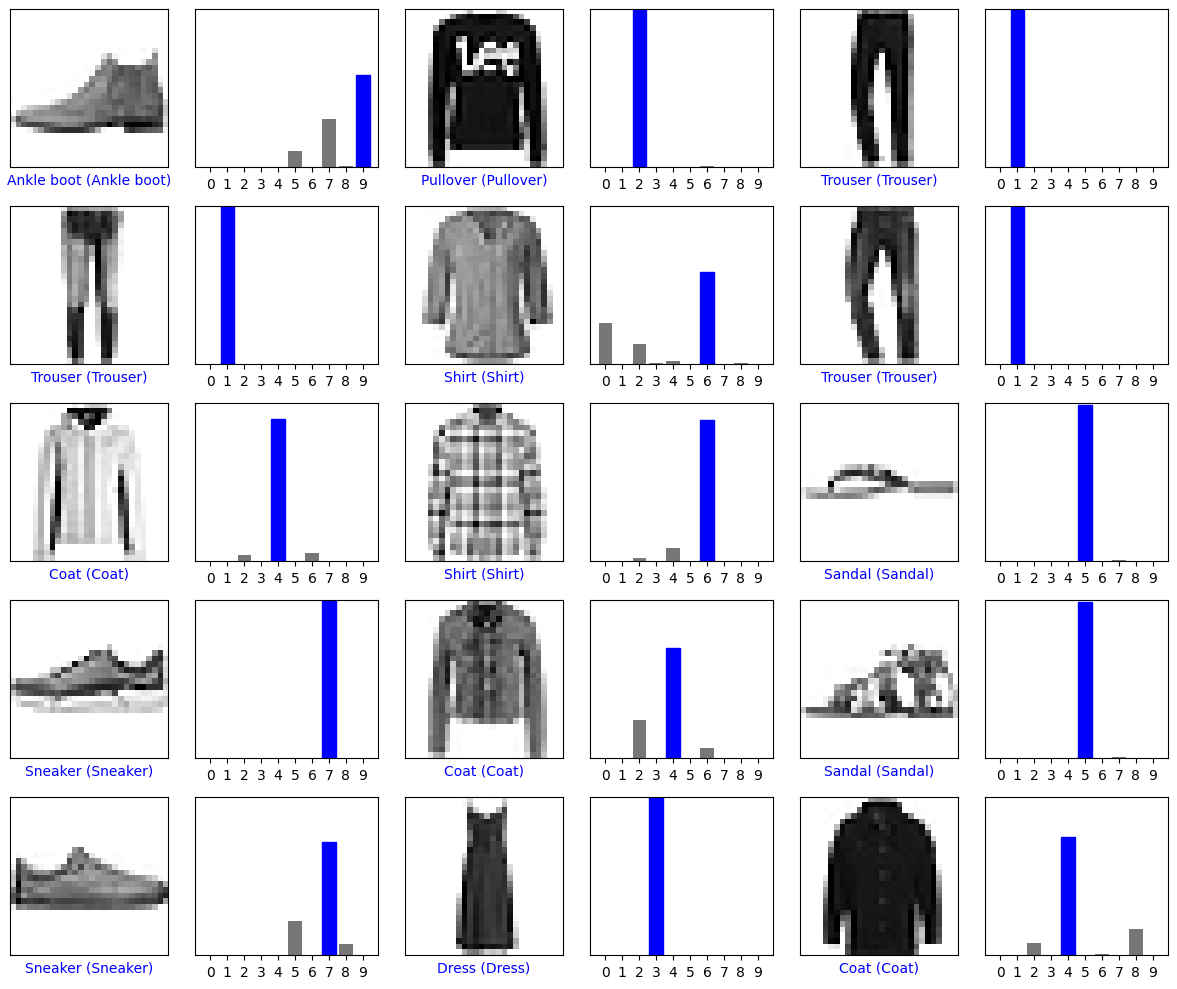

In [ ]:
predictions = model.predict(test_images)

# Function to plot the image, its true label, and the predicted label
def plot_image(i, predictions_array, true_label, img):
	true_label, img = true_label[i], img[i]
	plt.grid(False)
	plt.xticks([])
	plt.yticks([])

	plt.imshow(img, cmap=plt.cm.binary)

	predicted_label = np.argmax(predictions_array)
	if predicted_label == true_label:
		color = 'blue'
	else:
		color = 'red'

	plt.xlabel(f"{class_names[predicted_label]} ({class_names[true_label]})", color=color)

def plot_value_array(i, predictions_array, true_label):
	true_label = true_label[i]
	plt.grid(False)
	plt.xticks(range(10))
	plt.yticks([])
	thisplot = plt.bar(range(10), predictions_array, color="#777777")
	plt.ylim([0, 1])
	predicted_label = np.argmax(predictions_array)

	thisplot[predicted_label].set_color('red')
	thisplot[true_label].set_color('blue')

# Plot the first X test images, their predicted labels, and the true labels
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
	plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
	plot_image(i, predictions[i], test_labels, test_images)
	plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
	plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Finally, run inference with **TF Lite** on the Jetson Nano and compare with the previous execution's latency and memory usage.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset
(_, _), (test_images, test_labels) = fashion_mnist.load_data()

# Preprocess the test images (normalize and reshape)
test_images = test_images.astype(np.float32) / 255.0

# Select an image for inference
input_image = np.expand_dims(test_images[0], axis=0)

tflite_model_file = "fmnist"
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_file+".tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], input_image)

# Run the inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Print the output
print("Output:", output_data)

# Optionally, you can get the predicted class
predicted_class = np.argmax(output_data)
print("Predicted class:", predicted_class)

[{'name': 'serving_default_flatten_input:0', 'index': 0, 'shape': array([ 1, 28, 28], dtype=int32), 'shape_signature': array([-1, 28, 28], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 9, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output: [[5.70463089e-05 4.93176515e-07 1.69666127e-05 1.32243276e-05
  5.23068866e-06 1.04599334e-01 3.45230110e-05 3.02326351e-01
  1.00438753e-02 5.82902968e-01]]
Predicted class: 9


### CNNs on Tensor Flow Lite

Now it's your turn to develop a TF Lite application. This time make sure you train a convolutional model to classify or segment images from ImageNet or a similar dataset. Use the Jetson Board only to run inference both with Tensor Flow and TF Lite. Measure the CPU memory and time used by the application in both cases and estimate the energy consumed based on the nominal power consumption of each system or chip.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL as pl
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, AvgPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import  RandomBrightness, RandomFlip, RandomRotation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import os

import warnings
warnings.filterwarnings('ignore')

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
# prompt: drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


img shape:  (512, 512, 3)


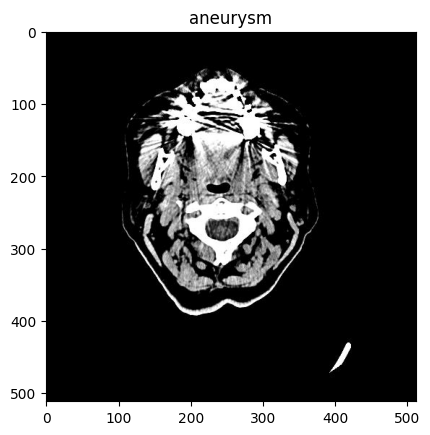

In [ ]:
img = cv2.imread('/content/drive/MyDrive/archive/files/aneurysm/0.jpg')
plt.title('aneurysm')
plt.imshow(img, label = 'aneurysm')
print("img shape: ",np.shape(img))

In [ ]:
dir = '/content/drive/MyDrive/archive/files'
img_width = 400
img_height = 400

In [ ]:
rescale = tf.keras.layers.Rescaling(1./255)

def preprocess_dataset(dataset):
    # Aplicar la reescalada a cada lote en el dataset
    return dataset.map(lambda x, y: (rescale(x), y))

train_data = image_dataset_from_directory(dir,label_mode = "categorical", image_size = (img_height, img_width),batch_size = 10, shuffle = True,seed = 12, validation_split = 0.3, subset = "training",  color_mode='grayscale')
test_data = image_dataset_from_directory(dir,label_mode = "categorical", image_size = (img_height, img_width),batch_size = 10, shuffle = True,seed = 12, validation_split = 0.2, subset = "validation", color_mode='grayscale')
val_data = image_dataset_from_directory(dir,label_mode = "categorical", image_size = (img_height, img_width),batch_size = 10, shuffle = True,seed = 12, validation_split = 0.1, subset = "validation", color_mode='grayscale')

# Preprocesar los datasets
train_batches = preprocess_dataset(train_data)
test_batches = preprocess_dataset(test_data)
val_batches = preprocess_dataset(val_data)

Found 265 files belonging to 3 classes.
Using 186 files for training.
Found 265 files belonging to 3 classes.
Using 53 files for validation.
Found 265 files belonging to 3 classes.
Using 26 files for validation.


In [ ]:
import tensorflow as tf
import os
import shutil

# Define image dimensions and batch size
img_height = 224
img_width = 224
batch_size = 10

# Directory containing the data
dir = '/content/drive/MyDrive/archive/files'

# Rescaling layer
rescale = tf.keras.layers.Rescaling(1./255)

def preprocess_dataset(dataset):
    # Apply rescaling to each batch in the dataset
    return dataset.map(lambda x, y: (rescale(x), y))

# Load the datasets with the appropriate validation splits and subsets
train_data = image_dataset_from_directory(
    dir,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=12,
    validation_split=0.3,
    subset="training",
    color_mode='grayscale'
)

val_data = image_dataset_from_directory(
    dir,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=12,
    validation_split=0.1,
    subset="validation",
    color_mode='grayscale'
)

test_data = image_dataset_from_directory(
    dir,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=12,
    validation_split=0.2,
    subset="validation",
    color_mode='grayscale'
)

# Preprocess the datasets
train_batches = preprocess_dataset(train_data)
val_batches = preprocess_dataset(val_data)
test_batches = preprocess_dataset(test_data)

# Helper function to save dataset to directories
def save_dataset(dataset, save_dir):
    if os.path.exists(save_dir):
        shutil.rmtree(save_dir)
    os.makedirs(save_dir)
    for images, labels in dataset:
        for i in range(images.shape[0]):
            label = tf.argmax(labels[i]).numpy()
            class_dir = os.path.join(save_dir, train_data.class_names[label])
            if not os.path.exists(class_dir):
                os.makedirs(class_dir)
            file_path = os.path.join(class_dir, f"img_{i}.png")
            tf.keras.preprocessing.image.save_img(file_path, images[i].numpy())

# Save the datasets
save_dataset(train_batches, 'train_data')
save_dataset(val_batches, 'val_data')
save_dataset(test_batches, 'test_data')


Found 265 files belonging to 3 classes.
Using 186 files for training.
Found 265 files belonging to 3 classes.
Using 26 files for validation.
Found 265 files belonging to 3 classes.
Using 53 files for validation.


In [ ]:
# Define the augmentation
augmentation = Sequential([
    tf.keras.layers.RandomBrightness(factor=0.2),
    tf.keras.layers.RandomFlip(mode='horizontal'),
    tf.keras.layers.RandomRotation(factor=0.2, fill_mode='nearest')
])

# Define the main model
model = Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 1)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    AvgPool2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 128)     640       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 128)     512       
 Normalization)                                                  
                                                                 
 average_pooling2d (Average  (None, 112, 112, 128)     0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)    

In [ ]:
 pip install -U memory_profiler

In [ ]:
import time
def train_model(model, train_data, val_data, epochs=200):

    early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=9, verbose=1)
    checkpoint = ModelCheckpoint(filepath='/best.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

    start_time = time.time()

    history = model.fit(train_data, validation_data=val_data, epochs=epochs, callbacks=[early_stopping, checkpoint])

    print("--- Training time %s seconds ---" % (time.time() - start_time))

    return history

In [ ]:
history = train_model(model, train_data, val_data)

Epoch 1/200
19/19 [==============================] - ETA: 0s - loss: 7.1836 - accuracy: 0.6452 
Epoch 1: val_accuracy improved from -inf to 0.19231, saving model to /best.keras
19/19 [==============================] - 246s 12s/step - loss: 7.1836 - accuracy: 0.6452 - val_loss: 994.7504 - val_accuracy: 0.1923
Epoch 2/200
19/19 [==============================] - ETA: 0s - loss: 1.6150 - accuracy: 0.8602 
Epoch 2: val_accuracy improved from 0.19231 to 0.57692, saving model to /best.keras
19/19 [==============================] - 219s 12s/step - loss: 1.6150 - accuracy: 0.8602 - val_loss: 109.2128 - val_accuracy: 0.5769
Epoch 3/200
19/19 [==============================] - ETA: 0s - loss: 0.7235 - accuracy: 0.9301 
Epoch 3: val_accuracy improved from 0.57692 to 0.69231, saving model to /best.keras
19/19 [==============================] - 202s 11s/step - loss: 0.7235 - accuracy: 0.9301 - val_loss: 66.3491 - val_accuracy: 0.6923
Epoch 4/200
19/19 [==============================] - ETA: 0s - lo

In [ ]:
loss, acc = model.evaluate(test_data)
print(f'\nAccuracy = {acc}\nLoss = {loss}')

In [ ]:
import pathlib

model_name = "Model_tf"
weigths_model ="model_weights.h5"
tf.saved_model.save(model, model_name)
model.save_weights(weigths_model)

converter = tf.lite.TFLiteConverter.from_saved_model(model_name)
tflite_model = converter.convert()
tflite_model_file = pathlib.Path(model_name+".tflite")
tflite_model_file.write_bytes(tflite_model)

start_time = time.time()
test_loss, test_acc = model.evaluate(test_data)
print('\nTest accuracy:', test_acc)
print("---Inference time %s seconds ---" % (time.time() - start_time))


6/6 [==============================] - 1s 33ms/step - loss: 1.7378 - accuracy: 0.8679

Test accuracy: 0.8679245114326477
---Inference time 0.8396339416503906 seconds ---


In [ ]:
import shutil
from google.colab import files

# Define the directory you want to compress and the output ZIP file name
directory_to_zip = '/content/Model_tf'  # Replace with your directory
output_zip_file = '/content/modeltf.zip'

# Compress the directory
shutil.make_archive(output_zip_file.replace('.zip', ''), 'zip', directory_to_zip)

# Download the ZIP file
files.download(output_zip_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tensorflow table comparation

|                    	| **Jetson** 	|    **Computer**    	|
|:------------------:	|:----------:	|:------------------:	|
| **Inference time** 	|      33.887439 S    	| 1.2872 S 	|
|       Memory       	|      767.3     	|      548.1 MiB     	|
|       Energy       	|      77.941 J     	|        85.85  J    	|

TFLITE

|                    	| **Jetson** 	| **Computer** 	|
|:------------------:	|:----------:	|:------------:	|
| **Inference time** 	|  2.2190 S  	|  0.319495 S  	|
|       Memory       	| 0 MiB 	|   597.1 MiB  	|
|       Energy       	|   5.10 J  	|    20.8 J   	|

## Conclusions

Memory is a very important factor when running an AI model on the jetson nano since the allocator tends to fill up very often, on the computer there was no problem but on the jetsion there was.

The execution time is considerable but it is compensated with the power consumption, because my computer has 65 W but compared to a jetson which is 2.3 it is much less.


### Video object detection

 As a final optional experiment, investigate a model for video object detection and demonstrate it working on the Jetson Nano board.